In [70]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [71]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn import linear_model, datasets
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [72]:
# This function is the Riegel formula for predicting race time T2 over distance D2 
# from a previous time T1 over a distance D1
def Riegel(T1_sec, D1, D2):
    T2_sec = (T1_sec) * (float(D2)/float(D1))**1.06
    return T2_sec

print 25*60
print Riegel(25*60, 5, 10)
print Riegel(3180, 10, 5)

# convert times in the format min:sec or min:sec:millisec (e.g. 14:32 or 14:32:00) to seconds
def time_to_secs(time):
    secs = int(float(str(time)[:2])*60 + float(str(time)[3:5]))
    return secs

# convert times in the format hour:min:sec to seconds
def time_to_secs_hours(time):
    secs = int(float(str(time)[0])*60*60 + float(str(time)[2:4])*60 + float(str(time)[6:8])*60)
    return secs

1500
3127.39728252
1525.22994973


In [73]:
# Read the data into a pandas dataframe

df_M = pd.read_csv('runbritain_data_2016_M_5K.csv')
print df_M.head()

   athleteid age_group     5K    10K     HM  Mar
0       5577       SEN  13:52    NaN    NaN  NaN
1      19569       U23  14:03  29:30    NaN  NaN
2      17296       SEN  14:04  29:55    NaN  NaN
3      12131       SEN  14:06    NaN    NaN  NaN
4      47493       SEN  14:06  29:43  65:24  NaN


(910, 4)
    5K   10K    HM   Mar
0  846  1794  3815  8400
1  875  1853  3950  8820
2  878  1856  4077  9000
3  883  1798  3986  9060
4  887  1874  4054  9180


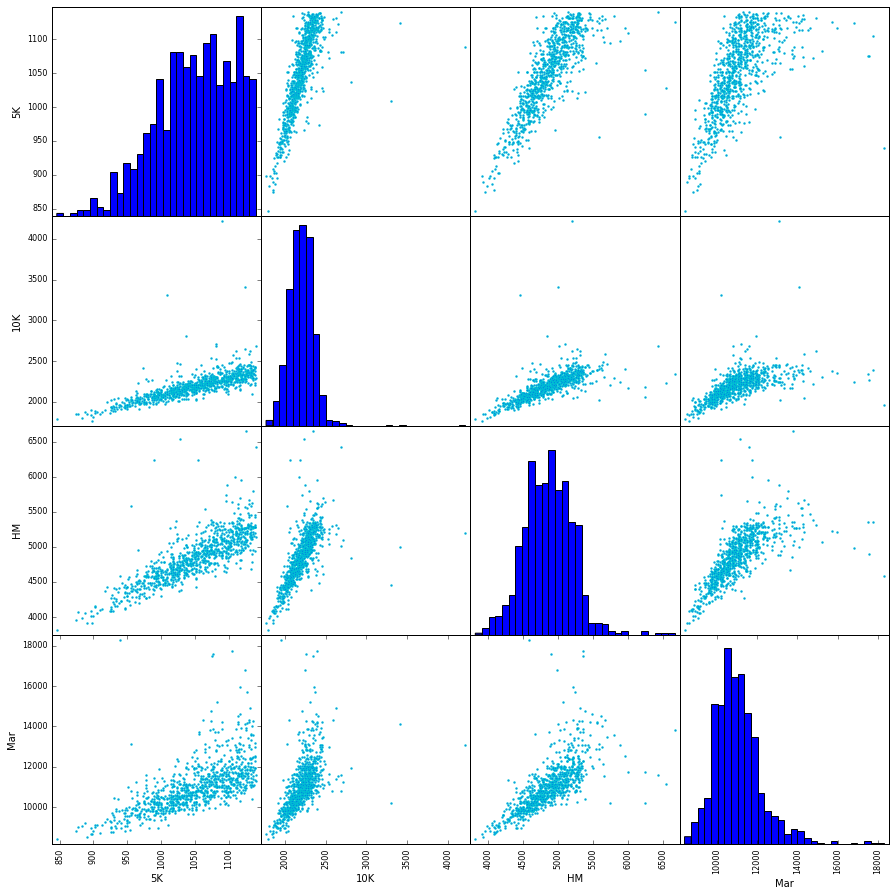

In [74]:
###### This needs improving - do using pandas, not converting to lists ######

# Plotting using only athletes who have times for all 4 distances (910 athletes)

# Create lists from the pandas dataframe, one for each column, for the entries that have times for all 4 events.
# Also convert the times into seconds
data_5K_M_full = []
data_10K_M_full = []
data_HM_M_full = []
data_Mar_M_full = []

for i in range(0, len(df_M['5K'])):
    if str(df_M['10K'][i]) != 'nan' and str(df_M['HM'][i]) != 'nan' and str(df_M['Mar'][i]) != 'nan':
        data_5K_M_full.append(time_to_secs(df_M['5K'][i]))
        data_10K_M_full.append(time_to_secs(df_M['10K'][i]))
        data_Mar_M_full.append(time_to_secs_hours(df_M['Mar'][i]))
        if int(str(df_M['HM'][i])[0]) > 3:
            data_HM_M_full.append(time_to_secs(df_M['HM'][i]))
        elif int(str(df_M['HM'][i])[0]) < 4:
            data_HM_M_full.append(time_to_secs_hours(df_M['HM'][i]))

# put the lists for each event into a list of lists
data_M_full = np.array([data_5K_M_full, data_10K_M_full, data_HM_M_full, data_Mar_M_full])

## Transpose the data and put it into a pandas dataframe with column headings
data_M_full_T = np.transpose(data_M_full)
print data_M_full_T.shape
labels = ["5K", "10K", "HM", "Mar"]
df_data_M_full = pd.DataFrame(data_M_full_T, columns=labels)
print df_data_M_full.head()

# Plot the data using a scatter matrix

axes = pd.scatter_matrix(df_data_M_full, figsize=(15, 15),
                      hist_kwds={'bins': 30}, s=10, alpha=.8, color = 'darkturquoise')

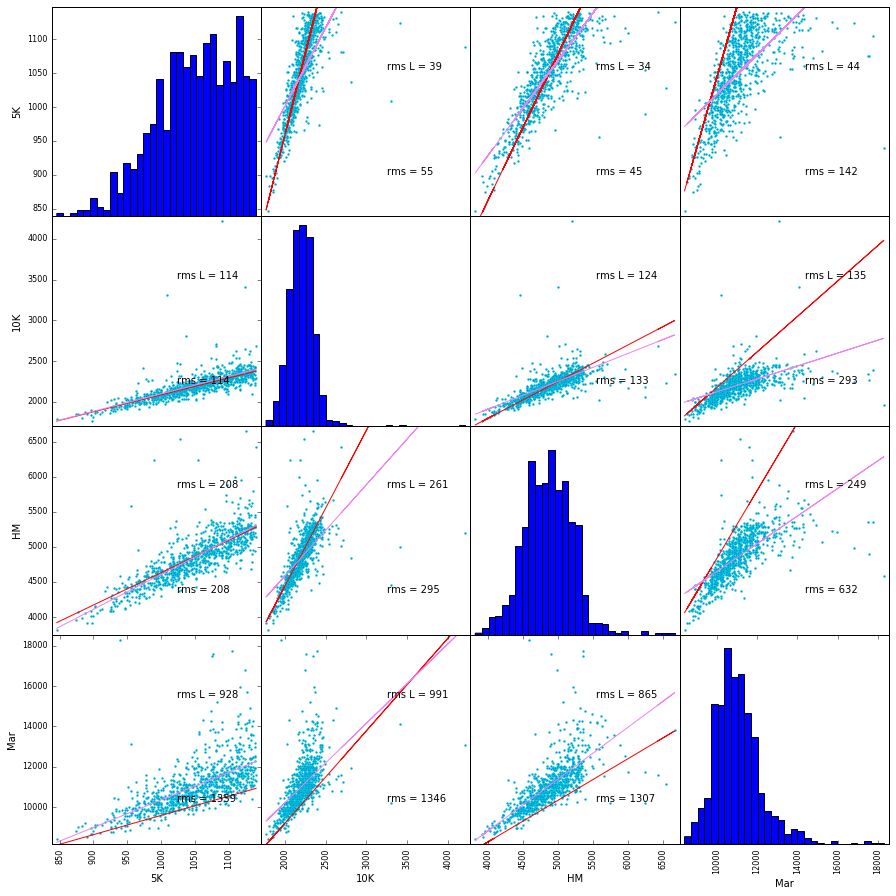

In [75]:
# Use the Riegel formula to predict the time of event 2 for each point in event 1 
# for all combinations of events

# Calculate a measure of how close the Reigel prediction is to the actual data using the root mean squared error

distances = [5, 10, 21.24334, 42.16481]
prediction = [[[]]*len(distances) for i in range(0, len(distances))]
ML_prediction = [[[]]*len(distances) for i in range(0, len(distances))]
#r_squared = [[[]]*len(distances) for i in range(0, len(distances))]
rms = [[[]]*len(distances) for i in range(0, len(distances))]
rms_ML = [[[]]*len(distances) for i in range(0, len(distances))]
for i in range(0, len(distances)):
    for j in range(0, len(distances)):
        prediction[i][j] = [Riegel(data_M_full[i][k], distances[i], distances[j]) for k in range(0, len(data_M_full[0]))]
#        slope, intercept, r_value, p_value, std_err = stats.linregress(prediction[i][j][:4], times[j][:4])
#        r_squared[i][j] = str(round(r_value, 2))
        rms_error = sqrt(mean_squared_error(data_M_full[j], prediction[i][j]))
        rms[i][j] = str(int(round(rms_error)))
        X = data_M_full[i].reshape(-1, 1)
        y = data_M_full[j].reshape(-1, 1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
        ridge = Ridge(alpha=0).fit(X_train, y_train)
        ML_prediction[i][j] = ridge.predict(X)
#            slope, intercept, r_value_ML, p_value, std_err = stats.linregress(np.array(ML_prediction[i][j]).reshape(-1)[:4], np.array(times[j])[:4])
#            r_squared_ML[i][j] = str(round(r_value_ML, 2))
        rms_error_ML = sqrt(mean_squared_error(data_M_full[j], np.array(ML_prediction[i][j]).reshape(-1)))
        rms_ML[i][j] = str(int(round(rms_error_ML)))
        
# Plot the data as before
axes = pd.scatter_matrix(df_data_M_full, figsize=(15, 15),
                      hist_kwds={'bins': 30}, s=10, alpha=.8, color = 'darkturquoise')

# Plot the Reigel predictions and rms as before and add the machine learning predicitons and rms errors.
for i in range(0, 4):
    for j in range(0, 4):
        if i != j:
            axes[j, i].plot(data_M_full[i], prediction[i][j], color = 'r')
            axes[j, i].plot(data_M_full[i], ML_prediction[i][j], color = 'violet')
#            axes[j,i].annotate("$R^2$ = " + r_squared[i][j], xy=(0.7, 0.1), xycoords="axes fraction")
#            axes[j,i].annotate("$R^2$ = " + r_squared_ML[i][j], xy=(0.7, 0.7), xycoords="axes fraction")
            axes[j,i].annotate("rms = " + rms[i][j], xy=(0.6, 0.2), xycoords="axes fraction")
            axes[j,i].annotate("rms L = " + rms_ML[i][j], xy=(0.6, 0.7), xycoords="axes fraction")

In [82]:
data_M_cleaned = [[], [], [], []]

z_scores = []
for i in data_M_full:
    z_scores.append(stats.zscore(i))

for j in range(0, len(z_scores[0])):
    if z_scores[0][j]<3 and z_scores[0][j]>-3:
        if z_scores[1][j]<3 and z_scores[1][j]>-3:
            if z_scores[2][j]<3 and z_scores[2][j]>-3:
                if z_scores[3][j]<3 and z_scores[3][j]>-3:
                    data_M_cleaned[0].append(data_M_full[0][j])
                    data_M_cleaned[1].append(data_M_full[1][j])
                    data_M_cleaned[2].append(data_M_full[2][j])
                    data_M_cleaned[3].append(data_M_full[3][j])


data_M_cleaned = np.array(data_M_cleaned)

print len(data_M_cleaned[0])
print len(data_M_cleaned[1])
print len(data_M_cleaned[2])
print len(data_M_cleaned[3])

886
886
886
886
(4, 886)
(4, 910)


In [60]:
# Use the Riegel formula to predict the time of event 2 for each point in event 1 
# for all combinations of events

# Calculate a measure of how close the Reigel prediction is to the actual data using the root mean squared error

# distances = [5, 10, 21.24334, 42.16481]
# prediction = [[[]]*len(distances) for i in range(0, len(distances))]
# ML_prediction = [[[]]*len(distances) for i in range(0, len(distances))]
# #r_squared = [[[]]*len(distances) for i in range(0, len(distances))]
# rms = [[[]]*len(distances) for i in range(0, len(distances))]
# rms_ML = [[[]]*len(distances) for i in range(0, len(distances))]
# for i in range(0, len(distances)):
#     for j in range(0, len(distances)):
#         prediction[i][j] = [Riegel(data_M_cleaned[i][k], distances[i], distances[j]) for k in range(0, len(data_M_cleaned[0]))]
# #        slope, intercept, r_value, p_value, std_err = stats.linregress(prediction[i][j][:4], times[j][:4])
# #        r_squared[i][j] = str(round(r_value, 2))
#         rms_error = sqrt(mean_squared_error(data_M_cleaned[j], prediction[i][j]))
#         rms[i][j] = str(int(round(rms_error)))
#         X = data_M_cleaned[i].reshape(-1, 1)
#         y = data_M_cleaned[j].reshape(-1, 1)
#         X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
#         ridge = Ridge(alpha=0).fit(X_train, y_train)
#         ML_prediction[i][j] = ridge.predict(X)
# #            slope, intercept, r_value_ML, p_value, std_err = stats.linregress(np.array(ML_prediction[i][j]).reshape(-1)[:4], np.array(times[j])[:4])
# #            r_squared_ML[i][j] = str(round(r_value_ML, 2))
#         rms_error_ML = sqrt(mean_squared_error(data_M_cleaned[j], np.array(ML_prediction[i][j]).reshape(-1)))
#         rms_ML[i][j] = str(int(round(rms_error_ML)))

data_M_cleaned_T = np.transpose(data_M_cleaned)
print data_M_cleaned_T.shape
labels = ["5K", "10K", "HM", "Mar"]
df_data_M_cleaned = pd.DataFrame(data_M_cleaned_T, columns=labels)
print df_data_M_cleaned.head()

# Plot the data as before
axes = pd.scatter_matrix(df_data_M_cleaned, figsize=(15, 15),
                      hist_kwds={'bins': 30}, s=10, alpha=.8, color = 'darkturquoise')

# # Plot the Reigel predictions and rms as before and add the machine learning predicitons and rms errors.
# for i in range(0, 4):
#     for j in range(0, 4):
#         if i != j:
#             axes[j, i].plot(data_M_cleaned[i], prediction[i][j], color = 'r')
#             axes[j, i].plot(data_M_cleaned[i], ML_prediction[i][j], color = 'violet')
# #            axes[j,i].annotate("$R^2$ = " + r_squared[i][j], xy=(0.7, 0.1), xycoords="axes fraction")
# #            axes[j,i].annotate("$R^2$ = " + r_squared_ML[i][j], xy=(0.7, 0.7), xycoords="axes fraction")
#             axes[j,i].annotate("rms = " + rms[i][j], xy=(0.6, 0.2), xycoords="axes fraction")
#             axes[j,i].annotate("rms L = " + rms_ML[i][j], xy=(0.6, 0.7), xycoords="axes fraction")

(4,)


ValueError: Shape of passed values is (1, 4), indices imply (4, 4)